# Modeling

Now that we've explored our data and better understand some of the relationships between our outcome variable (banker's offer) and relevant covariates of interest (state of the board, game round), we can train some models on the data and see how well the predict the banker's offer. Specifically, our exploration suggests that there is a strong linear relationship between the offer and the remaining average board values, controlling for what round the game is in.

After fitting models and testing them, we found that the XGBoost model outperforms every other model in terms of out-of-sample error; however, this performance improvement is minimal compared to the linear regression model we found based on exploration. Therefore, given the tradeoff between performance and interpretability, I would prefer to explore the linear regression model (see below for analysis).

With the model finally built, I now have an offer calculator that I can use to mimic the banker's behavior in my 'Deal or No Deal' game simulator. However, the tradeoff with using linear regression to generate the offers is that the output is the expected value of the offer based on user-inputs; that is, it is possible to get negative offers with low enough values! As an alternative to avoid this potentially messy situation, I instead create a simple non-parametric sampler of the existing data to generate offer values that are more plausible from the status of the game.

In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

## modeling packages
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform

In [2]:
modeling_columns = ['ID', 'round', 'offer', 'remaining_avg', 'remaining_prop_right', 'remaining_prop_big', 'season']
data = pd.read_csv('../data/dond_processed_data.csv')
modeling_data = data.loc[data['offer'].notnull(),modeling_columns].reset_index(drop=True)

In [3]:
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1324 non-null   int64  
 1   round                 1324 non-null   int64  
 2   offer                 1324 non-null   float64
 3   remaining_avg         1324 non-null   float64
 4   remaining_prop_right  1324 non-null   float64
 5   remaining_prop_big    1324 non-null   float64
 6   season                1324 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 72.5 KB


In [4]:
modeling_data.head()

,ID,round,offer,remaining_avg,remaining_prop_right,remaining_prop_big,season
0,1,1,21000.0,170639.300000,0.600000,0.350000,1.0
1,1,2,37000.0,84129.066667,0.600000,0.266667,1.0
2,1,3,53000.0,98806.909091,0.636364,0.272727,1.0
3,1,4,77000.0,110734.375000,0.625000,0.250000,1.0
4,1,5,63000.0,95979.166667,0.500000,0.166667,1.0


## traditional machine learning approach

In the following section, I train a series of models using best practices for predictive analytics (train-test split, cross-validation and searching for hyperparameters/variables depending on the model class, and evaluating performance on out-of-sample data). One thing to note is that I stratify the initial sampling by season to account for the differences in the early round offers across the seasons that we identified during our exploration. 

From the results we can see that ensemble decision-tree methods (Random Forest, Gradient Boosted Trees, XGBoost) have the best performance on testing data, and that the XGBoost model slightly outperforms the rest of these models.

In [5]:
X = modeling_data.drop(columns=['offer', 'ID'])
y = modeling_data['offer']

## splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=X['season'])

## building pipelines for testing results
# Linear regression
categorical_features = ['round', 'season']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

linear_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFECV(estimator=LinearRegression(), step=1, cv=5, scoring='neg_mean_squared_error')),
    ('regressor', LinearRegression())
])

# Models other than linear regression
pipelines = {
    'random_forest': Pipeline([('model', RandomForestRegressor())]),
    'gradient_boosting': Pipeline([('model', GradientBoostingRegressor())]),
    'xgboost': Pipeline([('model', XGBRegressor())]),
    'knn': Pipeline([('model', KNeighborsRegressor())]),
    'linear_regression': linear_model_pipeline
}

param_grids = {
    'random_forest': {
        'model__n_estimators': randint(50, 200),
        'model__max_depth': randint(3, 20)
    },
    'gradient_boosting': {
        'model__n_estimators': randint(50, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 20)
    },
    'xgboost': {
        'model__n_estimators': randint(50, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 20)
    },
    'knn': {
        'model__n_neighbors': randint(1, 20),
        'model__weights': ['uniform', 'distance']
    },
    'linear_regression': {
        # No hyperparameters to tune for linear regression
    }
}

# Function to perform RandomizedSearchCV and evaluate model
def evaluate_model(pipeline, param_grid, X_train, y_train, X_test, y_test):
    if param_grid:  # Only perform RandomizedSearchCV if there are parameters to tune
        search = RandomizedSearchCV(pipeline, param_grid, n_iter=50, scoring='neg_mean_squared_error', 
                                    cv=5, random_state=42, n_jobs=-1, verbose=1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f'Best parameters: {search.best_params_}')
    else:  # For linear regression without hyperparameter tuning
        pipeline.fit(X_train, y_train)
        best_model = pipeline
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Test Root Mean Squared Error: {test_rmse}')
    
    return best_model, test_rmse

In [6]:
# Evaluate all models
results = {}
for name, pipeline in pipelines.items():
    print(f"Evaluating {name}...")
    best_model, test_rmse = evaluate_model(pipeline, param_grids[name], X_train, y_train, X_test, y_test)
    results[name] = {'model': best_model, 'test_rmse': test_rmse}

Evaluating random_forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__max_depth': 9, 'model__n_estimators': 70}
Test Root Mean Squared Error: 21348.897937129484
Evaluating gradient_boosting...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__learning_rate': 0.14483520224146101, 'model__max_depth': 3, 'model__n_estimators': 97}
Test Root Mean Squared Error: 19949.407542929326
Evaluating xgboost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__learning_rate': 0.15544899140769497, 'model__max_depth': 3, 'model__n_estimators': 100}
Test Root Mean Squared Error: 20124.398701720704
Evaluating knn...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__n_neighbors': 12, 'model__weights': 'uniform'}
Test Root Mean Squared Error: 36038.04909697815
Evaluating linear_regression...
Test Root Mean Squared Error: 26809.419360673706


In [7]:
# Output the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Test RMSE: {result['test_rmse']}")
    print()

Model: random_forest
Test RMSE: 21348.897937129484

Model: gradient_boosting
Test RMSE: 19949.407542929326

Model: xgboost
Test RMSE: 20124.398701720704

Model: knn
Test RMSE: 36038.04909697815

Model: linear_regression
Test RMSE: 26809.419360673706



## EDA informed linear model

In addition to the machine learning approach, I build a linear regression model based on the EDA completed, in addition to a few other linear regression models. From the model results we see that the linear regression model **C(round) * (remaining_avg + C(season))** has the best fit on the testing data, as it accounts for both the variation in round and season.

However, since I would also like to incorporate this into my game simulator *without* asking the player specifying which season they would like to be in, I instead choose the **C(round) * remaining_avg** linear model as my preferred model since it has performance on par with the machine learning models that were previously developed and would be more consistent with the state of the game in the Deal or No Deal simulator.

In [8]:
data_train = pd.concat([y_train, X_train], axis=1)
data_test = pd.concat([y_test, X_test], axis=1)

In [9]:
def get_lm_test_rmse(formula, y_col='offer', train_data=data_train, test_data=data_test):
    formula = f'{y_col} ~ {formula}'
    model = smf.ols(formula=formula, data=train_data).fit()
    rmse = np.sqrt(mean_squared_error(model.predict(test_data), test_data[y_col]))
    return {'model' : model, 'test_rmse' : rmse}

In [10]:
predictor_formulas = [
    'C(round)',
    'C(season)',
    'remaining_avg',
    'remaining_prop_right',
    'remaining_prop_big',
    'C(round) + remaining_avg',
    'C(round) + remaining_prop_right',
    'C(round) + remaining_prop_big',
    'C(season) + remaining_avg',
    'C(season) + remaining_prop_right',
    'C(season) + remaining_prop_big',
    'C(round) * remaining_avg', 
    'C(season) * remaining_avg',
    'C(round) * (remaining_avg + C(season))',
    'C(round) * C(season) * remaining_avg',
]

In [11]:
lm_results = {}
for formula in predictor_formulas:
    lm_results[formula] = get_lm_test_rmse(formula=formula)

In [12]:
for formula in lm_results:
    print(f"Model formula: {formula}")
    print(f"Test rmse: {lm_results[formula]['test_rmse']}")
    print()

Model formula: C(round)
Test rmse: 78924.1467626125

Model formula: C(season)
Test rmse: 88371.11323174875

Model formula: remaining_avg
Test rmse: 45110.04060233342

Model formula: remaining_prop_right
Test rmse: 82901.58660567927

Model formula: remaining_prop_big
Test rmse: 67255.72782395205

Model formula: C(round) + remaining_avg
Test rmse: 27213.314252689812

Model formula: C(round) + remaining_prop_right
Test rmse: 75463.62602482301

Model formula: C(round) + remaining_prop_big
Test rmse: 58070.29702287716

Model formula: C(season) + remaining_avg
Test rmse: 44629.110217259826

Model formula: C(season) + remaining_prop_right
Test rmse: 83018.04470334775

Model formula: C(season) + remaining_prop_big
Test rmse: 67557.59873156357

Model formula: C(round) * remaining_avg
Test rmse: 20862.360493877335

Model formula: C(season) * remaining_avg
Test rmse: 44719.794120515086

Model formula: C(round) * (remaining_avg + C(season))
Test rmse: 19978.967131002388

Model formula: C(round) * 

### Interpretting the model output

With the preferred model selected, let us take some time to understand some of the relationships found in the data. One significant benefit of using a linear regression model is its interpretability, and the statsmodels object provides a detailed and well-formatted summary. Overall, the model performs well for predictive purposes, but additional transformations to the data may be required to satisfy the linear regression modeling assumptions needed for statistical inference.

In symbolic notation, here is our model:

$offer$ = $\beta_{0}$ + $\Sigma_{j=1}^8\beta_{i}$ $I(round_{i})$ + $\beta_{9}$ $remainingavg$ + $\Sigma_{i=10}^{17}\beta_{i}$  $I(round_{i})$ * $remainingavg$

Beginning first with the degrees of freedom, we see that in addition to the intercept 17 coefficients were generated: One for each round (dropping the first round to avoid multicollinearity), one for the *remaining average* variable, and one for the interaction between the round and remaining average. A benefit of this model is that the number of coefficients will remain constant even as more game data are added, and the estimates of the parameters would like improve with more data. Looking next at the R-squared/adjusted R-squared, we see that 96% of the variation in the offer is explained by our model from the data it was trained on, even when accounting for the penalty for having many coefficients. Similarly, the probability of the F-statistic being basically 0 illustrates that our model is a statistically significant improvement over the null model i.e. using the average banker offer to estimate all offers. AIC, BIC, and Log-Likelihood are good model comparison tools for variable selection across linear regression models but are less useful for comparing model performance on unseen data since they are calculating from the data the model is trained on, so I will ignore them.

Next interpretting the parameter estimates, we see that the round coefficients and the intercept are not statistically significantly different from 0, which seems reasonable for our data based on the range of values that the offer can take on. The slope coefficient for remaining_avg and the interaction between the remaining_avg and the game round are all statistically significantly different from 0 with the exception of the interaction between remaining_avg and round 2. Based on the model, we can interpret the coefficients of the interaction terms as the difference in the slope between round 1 and the round of interest. The slope difference between rounds 1 and 2 is not statistically significantly different from 0, so the slopes are about the same, as the coefficient (0.0313) is generally smaller than the interaction term coefficient for any other round; in other words, for similar remaining values on the board, the first and second round offer are likely not going to be very different. 

Finally, the residual plots show us whether the model assumptions are reasonably satisfied to answer the question of interpretting whether the coefficients are statistically significant. The residuals vs fitted plot shows that there is a relationship between the estimated value and the error term, suggesting that the homoscedasiticty assumption may be violated; that is, the variation in the residuals is a function of the covariate values. Some outlier datapoints may be driving this behavior, based on the distance between the residual and zero. Additionally, the QQ-plot shows some deviation from the 45 degree line at the tails, suggesting that the residuals are not normally distributed.

In [13]:
final_model = lm_results['C(round) * remaining_avg']['model']
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  offer   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1120.
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:19:15   Log-Likelihood:                -8989.7
No. Observations:                 794   AIC:                         1.802e+04
Df Residuals:                     776   BIC:                         1.810e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.249e+04   1.01e+04     -1.235      0.217   -3.23e+04    7361.428
C(round)[T.2]                1.103e+04   1.23e+04      0.896      0.370   -1.31e+04    3.52e+04
C(round)[T.3]                4410.7721   1.14e+04      0.387      0.699    -1.8e+04    2.68e+04
C(round)[T.4]                5636.4245    1.1e+04      0.514      0.608   -1.59e+04    2.72e+04
C(round)[T.5]                9194.8588   1.08e+04      0.854      0.394   -1.19e+04    3.03e+04
C(round)[T.6]                1.185e+04   1.07e+04      1.104      0.270   -9225.929    3.29e+04
C(round)[T.7]                8785.8420   1.06e+04      0.825      0.409   -1.21e+04    2.97e+04
C(round)[T.8]                7202.0842   1.06e+04      0.680      0.496   -1.36e+04     2.8e+04
C(round)[T.9]                1.028e+04   1.08e+04      0.948      0.343    -1.1e+04    3.16e+04
remaining_avg                   0.2815      0.075      3.777      0.000       0.135       0.428
C(round)[T.2]:remaining_avg     0.0313      0.090      0.348      0.728      -0.145       0.208
C(round)[T.3]:remaining_avg     0.2225      0.083      2.673      0.008       0.059       0.386
C(round)[T.4]:remaining_avg     0.3156      0.080      3.962      0.000       0.159       0.472
C(round)[T.5]:remaining_avg     0.3792      0.078      4.840      0.000       0.225       0.533
C(round)[T.6]:remaining_avg     0.4656      0.078      5.999      0.000       0.313       0.618
C(round)[T.7]:remaining_avg     0.6333      0.077      8.232      0.000       0.482       0.784
C(round)[T.8]:remaining_avg     0.7200      0.076      9.472      0.000       0.571       0.869
C(round)[T.9]:remaining_avg     0.7713      0.076     10.155      0.000       0.622       0.920
==============================================================================
Omnibus:                       90.887   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.241
Skew:                           0.357   Prob(JB):                    1.42e-104
Kurtosis:                       6.734   Cond. No.                     7.69e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

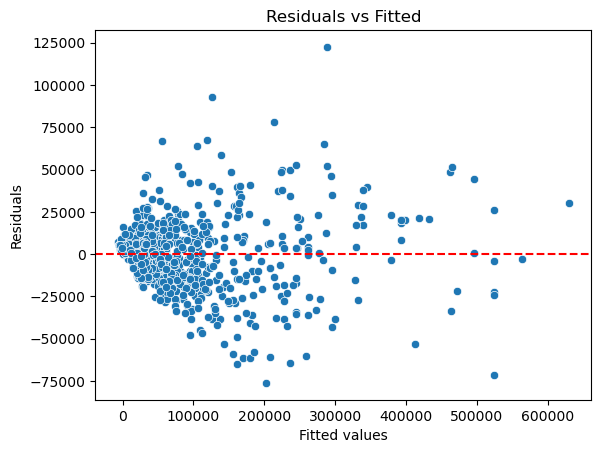

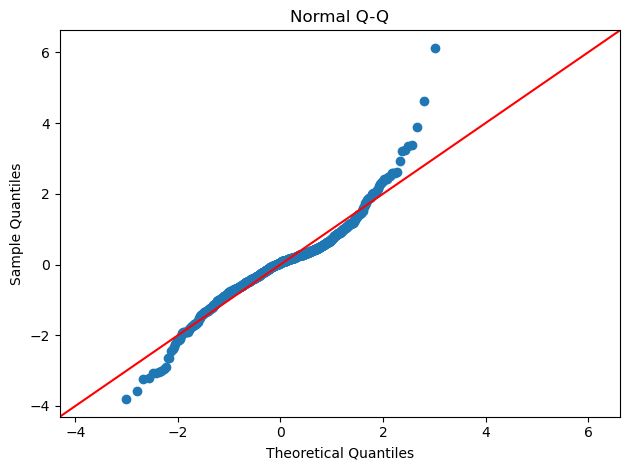

In [14]:
fitted_values = final_model.fittedvalues
residuals = final_model.resid

# Residuals vs Fitted
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# QQ Plot
sm.qqplot(residuals, line ='45', fit=True)
plt.title('Normal Q-Q')

plt.tight_layout()
plt.show()

In [15]:
with open('../game/dond_lm_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

#### Simulating from the model

Linear regression model can predict and extrapolate based on the inputs to the model. This allows the model to make predictions even on values from predictors that it was not trained on, although the validity of these extrapolations will depend on whether you think it is appropriate to assume a linear relationship between the predictor variables and the outcome variable still exists for these values. That being said, lets try simulating some data and passing it through the model to see what results we get. Since these are average predictions, the expected value of the offer for a given input will not have the same level of rounding usually offered in the game i.e. 106000 vs 105743.27.

One quirk of using the model is that the expected value prediction can occasionally be negative based on input values. These combination of inputs become more common as the game goes on, where, based on the model coefficients, the remaining average value may not be sufficiently large to exceed the intercept, even when multiplied by the round's slope. I've included some simulations below as an example of the potentially unintended side-effects of using this model during the Deal or No Deal simulation game.

In [16]:
np.random.seed(0)
n_sims = 1000
counter = 0
for i, t in enumerate(zip(np.random.randint(1, 9+1, n_sims), np.random.choice(a=modeling_data['remaining_avg'], size=n_sims))):
    sim_pred = final_model.predict({'round' : t[0], 'remaining_avg' : t[1]}).iloc[0]
    if sim_pred < 0 or i % 20 == 0:
        print(f'Iteration: {i}, Round: {t[0]}, Remaining Average: {t[1]}, Predicted Offer: {sim_pred}')
        counter += 1
    if counter >= 10:
        break

Iteration: 0, Round: 6, Remaining Average: 163418.8, Predicted Offer: 121451.97964274883
Iteration: 20, Round: 9, Remaining Average: 134170.55049999998, Predicted Offer: 139050.8623594858
Iteration: 26, Round: 1, Remaining Average: 55.0, Predicted Offer: -12475.123829350176
Iteration: 35, Round: 1, Remaining Average: 40873.125, Predicted Offer: -984.4220610518769
Iteration: 40, Round: 4, Remaining Average: 168291.00090909092, Predicted Offer: 93636.51103625906
Iteration: 54, Round: 9, Remaining Average: 102.5, Predicted Offer: -2102.0954610797394
Iteration: 60, Round: 8, Remaining Average: 148783.18181818182, Predicted Offer: 143721.28667619237
Iteration: 62, Round: 1, Remaining Average: 40083.2, Predicted Offer: -1206.7936813632714
Iteration: 80, Round: 2, Remaining Average: 222825.5463636364, Predicted Offer: 68241.91340060196
Iteration: 87, Round: 3, Remaining Average: 201.0, Predicted Offer: -7978.526242757426



#### Banker offer generator

Because of the potential for negative banker offers with the linear regression model, I create a method that samples the observations from the existing data in order to generate a banker offer that is guaranteed to not be negative. The offer bootstraps the data based on the round and remaining average value left on the board for the player.

In [17]:
## generating the model dictionary to filter during the game
tuple_sort = lambda l: tuple(sorted(l))
offer_ratio_dict = data.query('offer.notnull()').groupby('round')['offer_avg_ratio'].apply(tuple_sort).to_dict()
remaining_avg_dict = data.query('offer.notnull()').groupby('round')['remaining_avg'].apply(tuple_sort).to_dict()
model_dict = {k : {'remaining_avg' : remaining_avg_dict[k], 'offer_avg_ratio' : offer_ratio_dict[k]} for k in remaining_avg_dict}

In [18]:
with open('../game/dond_dict_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)